# Time Series - Chicago Crime Data

#### Import required libraries and daily crime data prepped in R

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
df_dly_crm = pd.read_csv('chicago_daily_crime.csv')
#df_dly_crm = pd.read_csv('../input/chicago-daily-crime/chicago_daily_crime.csv')
df_dly_crm.columns = ['Ct', 'Date']
df_dly_crm.head()

,Ct,Date
0,1821,2001-01-01 23:59:54
1,1143,2001-01-02 23:55:00
2,1151,2001-01-03 23:59:00
3,1166,2001-01-04 23:55:01
4,1267,2001-01-05 23:59:00


#### Daily Crime - Entire Span - Initial Time Series Plot

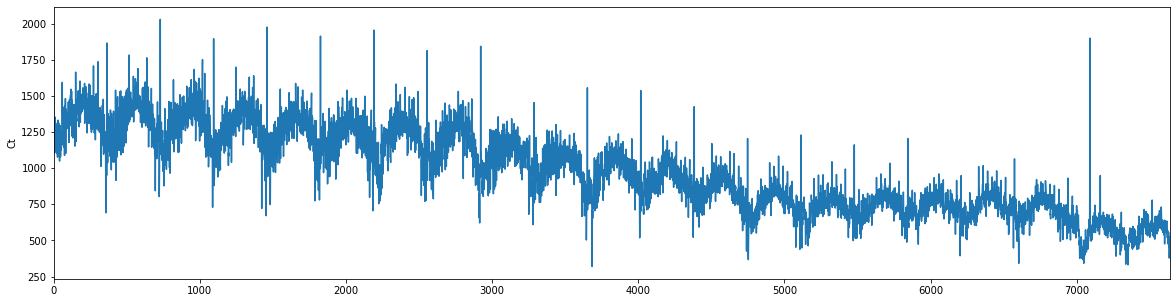

In [3]:
fig = plt.figure(figsize=(20,5))
sns.lineplot(data=df_dly_crm['Ct']).margins(x=0)
#sns.lineplot(data=df[['date_time', 'deg_C']][4000:4100], x='date_time', y='deg_C').margins(x=0)
#plt.xticks(rotation=90)
#plt.title('deg_C')
plt.show()

### Feature Engineering for Classical ML Regression  
    - Feature Engineering necessary for Random Forests, etc
    - Turn Time Series Forecasting into Tabular Regression Problem
    - No Data Prep will be necessary for LSTMs

#### Add Columns for Daily count at lag 1, lag 2, etc.

In [4]:
#df_dly_crm['Lag_1_Day']=df_dly_crm['Ct'].shift(1)
for i in range(1,15):
    #print(i)
    df_dly_crm['Lag_'+str(i)+'_Day']=df_dly_crm['Ct'].shift(i)
    
df_dly_crm.head()

,Ct,Date,Lag_1_Day,Lag_2_Day,Lag_3_Day,Lag_4_Day,Lag_5_Day,Lag_6_Day,Lag_7_Day,Lag_8_Day,Lag_9_Day,Lag_10_Day,Lag_11_Day,Lag_12_Day,Lag_13_Day,Lag_14_Day
0,1821,2001-01-01 23:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1143,2001-01-02 23:55:00,1821.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1151,2001-01-03 23:59:00,1143.0,1821.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1166,2001-01-04 23:55:01,1151.0,1143.0,1821.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1267,2001-01-05 23:59:00,1166.0,1151.0,1143.0,1821.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_dly_crm.columns

Index(['Ct', 'Date', 'Lag_1_Day', 'Lag_2_Day', 'Lag_3_Day', 'Lag_4_Day',
       'Lag_5_Day', 'Lag_6_Day', 'Lag_7_Day', 'Lag_8_Day', 'Lag_9_Day',
       'Lag_10_Day', 'Lag_11_Day', 'Lag_12_Day', 'Lag_13_Day', 'Lag_14_Day'],
      dtype='object')

#### Add Moving Average Features

#### Add Date Features

In [6]:
df_dly_crm['date_time'] = pd.to_datetime(df_dly_crm['Date'])
df_dly_crm['date_time_2'] = df_dly_crm['date_time'].astype('datetime64[ns]').astype(np.int64)/10**9
df_dly_crm['year'] = df_dly_crm['date_time'].dt.year
df_dly_crm['month'] = df_dly_crm['date_time'].dt.month
df_dly_crm['week'] = df_dly_crm['date_time'].dt.week
df_dly_crm['day'] = df_dly_crm['date_time'].dt.day
df_dly_crm['dayofweek'] = df_dly_crm['date_time'].dt.dayofweek

#add a day of the year function?

<ipython-input-6-f7484ae99203>:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df_dly_crm['week'] = df_dly_crm['date_time'].dt.week


In [7]:
#df_dly_crm.iloc[25:35,]
#Keep pandas dates instead
#df_dly_crm.info()
df_dly_crm.pop('Date')
df_dly_crm.columns

Index(['Ct', 'Lag_1_Day', 'Lag_2_Day', 'Lag_3_Day', 'Lag_4_Day', 'Lag_5_Day',
       'Lag_6_Day', 'Lag_7_Day', 'Lag_8_Day', 'Lag_9_Day', 'Lag_10_Day',
       'Lag_11_Day', 'Lag_12_Day', 'Lag_13_Day', 'Lag_14_Day', 'date_time',
       'date_time_2', 'year', 'month', 'week', 'day', 'dayofweek'],
      dtype='object')

#### Create X and Y after feature engineering, choose which fields to add to X

In [8]:
df_dly_crm=df_dly_crm.dropna()
Y=df_dly_crm['Ct']
X=df_dly_crm[['Lag_1_Day', 'Lag_2_Day', 'Lag_3_Day', 'Lag_4_Day','Lag_5_Day', 
              'Lag_6_Day', 'Lag_7_Day', 'Lag_8_Day', 'Lag_9_Day','Lag_10_Day', 
              'Lag_11_Day', 'Lag_12_Day', 'Lag_13_Day','Lag_14_Day','year', 'month', 'week', 
              'day', 'dayofweek', 'date_time_2']]
# X=df_dly_crm[['Lag_1_Day', 'Lag_2_Day', 'Lag_3_Day', 'Lag_4_Day','Lag_5_Day', 
#               'Lag_6_Day', 'Lag_7_Day', 'Lag_8_Day', 'Lag_9_Day','Lag_10_Day', 
#               'Lag_11_Day', 'Lag_12_Day', 'Lag_13_Day','Lag_14_Day',
#        'Lag_15_Day', 'Lag_16_Day', 'Lag_17_Day', 'Lag_18_Day', 'Lag_19_Day',
#        'Lag_20_Day', 'Lag_21_Day', 'Lag_22_Day', 'Lag_23_Day', 'Lag_24_Day',
#        'Lag_25_Day', 'Lag_26_Day', 'Lag_27_Day','Lag_28_Day', 'Lag_29_Day',
#        'Lag_30_Day', 'Lag_31_Day', 'Lag_32_Day', 'Lag_33_Day', 'Lag_34_Day',
#        'Lag_35_Day','year', 'month', 'week', 
#               'day', 'dayofweek', 'date_time_2']]

#### Import Supervised Learning Models

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as MSE
import sklearn.model_selection as cv

#### Separate Train and Test Data

In [10]:
#Because Data is now in Tabular Form, do not have to worry about a rolling window TS CV
X_train, X_test, y_train, y_test = cv.train_test_split(X,Y,test_size=0.3)

In [11]:
import time
t_start = time.time()

rf_reg = RandomForestRegressor(n_estimators=1000,n_jobs=10)
rf_reg.fit(X_train,y_train)

t_stop = time.time()
print('Time elapsed: {:.3f} seconds'.format(t_stop - t_start))

Time elapsed: 5.256 seconds


#### Check Accuracy on Hold Out Test Set

In [12]:
#2500 trees - 73.5164748196696
#1000 trees - 73.36016951406296
#500 trees - 73.6176
#5000 trees - 73.3579
#100 trees - 73.255
#10,000 trees - 73.3524
y_pred = rf_reg.predict(X_test)
tree_mse = MSE(y_test, y_pred)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

76.80626317866017

#### Check Accuracy using Cross Validation

In [13]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())


import time
t_start = time.time()

scores = cross_val_score(rf_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

t_stop = time.time()
print('Time elapsed: {:.3f} seconds'.format(t_stop - t_start))

Scores: [68.47558572 99.32318113 75.89038959 76.3298651  74.02515056 66.72632119
 87.04873222 64.37189512 69.6110355  71.69788366]
Mean: 75.35000397987237
Standard deviation: 10.014983743191399
Time elapsed: 47.086 seconds


#### Look at Feature Importance

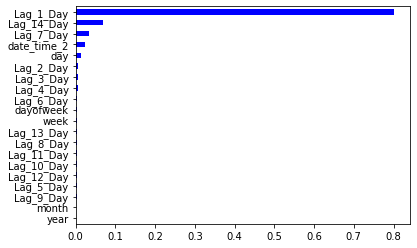

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
# Create a pd.Series of features importances
importances_rf = pd.Series(rf_reg.feature_importances_,
index = X.columns)
# Sort importances_rf
sorted_importances_rf = importances_rf.sort_values()
# Make a horizontal bar plot
sorted_importances_rf.plot(kind='barh', color='blue')
plt.show()

In [15]:
sorted_importances_rf

year           0.000826
month          0.001845
Lag_9_Day      0.003288
Lag_5_Day      0.003520
Lag_12_Day     0.003530
Lag_10_Day     0.003778
Lag_11_Day     0.003811
Lag_8_Day      0.003854
Lag_13_Day     0.003912
week           0.004272
dayofweek      0.004430
Lag_6_Day      0.004504
Lag_4_Day      0.005040
Lag_3_Day      0.005077
Lag_2_Day      0.006034
day            0.014805
date_time_2    0.022538
Lag_7_Day      0.032909
Lag_14_Day     0.069694
Lag_1_Day      0.802332
dtype: float64

## Forecast Future Values

#### Define Function to create new row and append to Data Frame

In [16]:
# Create New Row for Future Time Step's Predictors
def forecast_new_row(df):

    new_row=[]
    #Add next time_step's lagged variables
    Lag_1_Day=df.iloc[-1]['Ct']
    new_row.append(Lag_1_Day)
    Lag_2_Day=df.iloc[-1]['Lag_1_Day']
    new_row.append(Lag_2_Day)
    Lag_3_Day=df.iloc[-1]['Lag_2_Day']
    new_row.append(Lag_3_Day)
    Lag_4_Day=df.iloc[-1]['Lag_3_Day']
    new_row.append(Lag_4_Day)
    Lag_5_Day=df.iloc[-1]['Lag_4_Day']
    new_row.append(Lag_5_Day)
    Lag_6_Day=df.iloc[-1]['Lag_5_Day']
    new_row.append(Lag_6_Day)
    Lag_7_Day=df.iloc[-1]['Lag_6_Day']
    new_row.append(Lag_7_Day)
    Lag_8_Day=df.iloc[-1]['Lag_7_Day']
    new_row.append(Lag_8_Day)
    Lag_9_Day=df.iloc[-1]['Lag_8_Day']
    new_row.append(Lag_9_Day)
    Lag_10_Day=df.iloc[-1]['Lag_9_Day']
    new_row.append(Lag_10_Day)
    Lag_11_Day=df.iloc[-1]['Lag_10_Day']
    new_row.append(Lag_11_Day)
    Lag_12_Day=df.iloc[-1]['Lag_11_Day']
    new_row.append(Lag_12_Day)
    Lag_13_Day=df.iloc[-1]['Lag_12_Day']
    new_row.append(Lag_13_Day)
    Lag_14_Day=df.iloc[-1]['Lag_13_Day']
    new_row.append(Lag_14_Day)

    #Add next time_step's Date Features
    date_time=df.iloc[-1:]['date_time']+pd.to_timedelta(pd.np.ceil(1),unit="D")

    date_time_2=date_time.astype('datetime64[ns]').astype(np.int64)/10**9
    year=date_time.dt.year
    month=date_time.dt.month
    week=date_time.dt.week
    day=date_time.dt.day
    dayofweek=date_time.dt.dayofweek

    #convert Date Series Objects to Regular? Date Objects
    date_time=date_time.iloc[0]
    new_row.append(date_time)
    date_time_2=date_time_2.iloc[0]
    new_row.append(date_time_2)
    year=year.iloc[0]
    new_row.append(year)
    month=month.iloc[0]
    new_row.append(month)
    week=week.iloc[0]
    new_row.append(week)
    day=day.iloc[0]
    new_row.append(day)
    dayofweek=dayofweek.iloc[0]
    new_row.append(dayofweek)

    #Predict future Y Value using Next Time Step's New Row


    df_new_row=pd.DataFrame(new_row).T
    df_new_row.columns=[['Lag_1_Day', 'Lag_2_Day', 'Lag_3_Day', 'Lag_4_Day', 'Lag_5_Day','Lag_6_Day', 
                         'Lag_7_Day', 'Lag_8_Day', 'Lag_9_Day', 'Lag_10_Day',
                         'Lag_11_Day', 'Lag_12_Day', 'Lag_13_Day', 'Lag_14_Day', 
                         'date_time','date_time_2', 'year', 'month', 'week', 'day', 'dayofweek']]

    #extra step allows one to hand select features
    X_last=df_new_row[['Lag_1_Day', 'Lag_2_Day', 'Lag_3_Day', 'Lag_4_Day','Lag_5_Day', 
                       'Lag_6_Day', 'Lag_7_Day', 'Lag_8_Day', 'Lag_9_Day','Lag_10_Day', 
                       'Lag_11_Day', 'Lag_12_Day', 'Lag_13_Day','Lag_14_Day','year', 'month', 'week', 
                       'day', 'dayofweek', 'date_time_2']]

    Y_new=rf_reg.predict(X_last)


    #Add new row with predicted Y to originaly data frame


    #add new row with predicted count to originaly data frame - df
    fin_list=[]
    fin_list.append(Y_new[0])
    fin_list_2=fin_list+new_row

    df_new_row_fin=pd.DataFrame(fin_list_2).T.reset_index()
    df_new_row_fin.pop('index')
    df_new_row_fin.columns=['Ct', 'Lag_1_Day', 'Lag_2_Day', 'Lag_3_Day', 'Lag_4_Day', 'Lag_5_Day',
                             'Lag_6_Day', 'Lag_7_Day', 'Lag_8_Day', 'Lag_9_Day', 'Lag_10_Day',
                             'Lag_11_Day', 'Lag_12_Day', 'Lag_13_Day', 'Lag_14_Day', 'date_time',
                             'date_time_2', 'year', 'month', 'week', 'day', 'dayofweek'] 
    return(df_new_row_fin)

In [17]:
n_row=forecast_new_row(df_dly_crm)
df_forecast=pd.concat([df_dly_crm,n_row])
#df_forecast

<ipython-input-16-c7072e9843d3>:36: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  date_time=df.iloc[-1:]['date_time']+pd.to_timedelta(pd.np.ceil(1),unit="D")
<ipython-input-16-c7072e9843d3>:41: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  week=date_time.dt.week


## Random Forest - Nov 2021 Forecasting

In [18]:
df_train = df_dly_crm[df_dly_crm['date_time']<'2021-11-01']
df_test = df_dly_crm[df_dly_crm['date_time']>='2021-11-01']
#using train dataset, forecast 27 days of Nov 1st to Nov 27th

In [19]:
for idx in range(1, 28):
    n_row=forecast_new_row(df_train)
    df_train=pd.concat([df_train,n_row])

<ipython-input-16-c7072e9843d3>:36: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  date_time=df.iloc[-1:]['date_time']+pd.to_timedelta(pd.np.ceil(1),unit="D")
<ipython-input-16-c7072e9843d3>:41: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  week=date_time.dt.week
<ipython-input-16-c7072e9843d3>:36: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  date_time=df.iloc[-1:]['date_time']+pd.to_timedelta(pd.np.ceil(1),unit="D")
<ipython-input-16-c7072e9843d3>:41: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  week=date_time.dt.week
<ipython-input-16-c7072e9843d3>:36: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future 

<ipython-input-16-c7072e9843d3>:36: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  date_time=df.iloc[-1:]['date_time']+pd.to_timedelta(pd.np.ceil(1),unit="D")
<ipython-input-16-c7072e9843d3>:41: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  week=date_time.dt.week
<ipython-input-16-c7072e9843d3>:36: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  date_time=df.iloc[-1:]['date_time']+pd.to_timedelta(pd.np.ceil(1),unit="D")
<ipython-input-16-c7072e9843d3>:41: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  week=date_time.dt.week
<ipython-input-16-c7072e9843d3>:36: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future 

In [20]:
y_pred=df_train[df_train['date_time']>='2021-11-01']['Ct']
y_test=df_test['Ct']

#### Join Test and Pred together as 1 Pandas Data Frame

In [21]:
df_y_pred=pd.DataFrame(y_pred)
df_y_test=pd.DataFrame(y_test)

df_y_pred=df_y_pred.reset_index()
df_y_pred.pop('index')
df_y_test=df_y_test.reset_index()
df_y_test.pop('index')

df_y_test.columns=['ct_test']
df_y_pred.columns=['ct_pred']
cmp=df_y_test.join(df_y_pred, how='inner')

cmp['ct_pred']=cmp['ct_pred'].astype(float)

#### Find Random Forests - Root Mean Squared Error for November

In [22]:
from sklearn.metrics import mean_squared_error

rms = mean_squared_error(y_pred, y_test, squared=False)
rms

59.00285248911151

#### Random Forest Predicted - Chicago Crime - November 2021

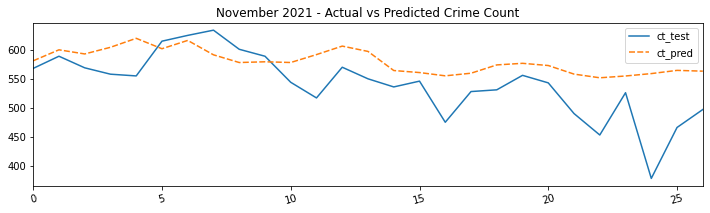

In [23]:
fig = plt.figure(figsize=(12,3))
sns.lineplot(data=cmp).margins(x=0)
plt.xticks(rotation=15)
plt.title('November 2021 - Actual vs Predicted Crime Count')
plt.show()

# LSTMs - Nov 2021

In [ ]:
#https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
#https://stackoverflow.com/questions/37232782/nan-loss-when-training-regression-network

In [133]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import keras
import tensorflow

import tensorflow.keras
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import numpy as np

from keras.layers.convolutional import Conv1D, MaxPooling1D


import keras.utils
from keras import utils as np_utils

from keras.utils import np_utils


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Convolution1D, Flatten, LeakyReLU
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalAveragePooling1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import SpatialDropout1D, MaxPooling1D, Bidirectional, GRU, concatenate


# import necessary tools and models 
import seaborn as sns
import matplotlib.pyplot as plt 

import sklearn.model_selection as cv
from sklearn.model_selection import cross_val_score
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from keras.regularizers import l2, l1_l2

### Multiple Input Multi-Step Output

In [26]:
# multivariate multi-step stacked lstm example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
 

### Re Load Daily Crime

In [32]:
df_daily_crime = pd.read_csv('chicago_daily_crime.csv')
#df_dly_crm = pd.read_csv('../input/chicago-daily-crime/chicago_daily_crime.csv')
df_daily_crime.columns = ['Ct', 'Date']

In [64]:
df_daily_crime['date_time'] = pd.to_datetime(df_daily_crime['Date'])

In [86]:
# #QA Check
# df_daily_crime['Year'] = df_daily_crime['date_time'].apply(lambda x: "%d" % (x.year))
# df_daily_crime.groupby(['Year']).size()

#### Truncate Daily Crime so its between Jan 2001 and Oct 2021

In [88]:
df_daily_crime_2=df_daily_crime[(df_daily_crime['date_time']>='2001-01-01') & (df_daily_crime['date_time']<'2021-11-01')]
df_daily_crime_2.head(3)

,Ct,Date,date_time,Year
0,1821,2001-01-01 23:59:54,2001-01-01 23:59:54,2001
1,1143,2001-01-02 23:55:00,2001-01-02 23:55:00,2001
2,1151,2001-01-03 23:59:00,2001-01-03 23:59:00,2001


### Load Daily Temperature for Chicago

In [42]:
df_weather=pd.read_csv('chicago_weather_2813591.csv')
df_weather['date_time'] = pd.to_datetime(df_daily_weather['DATE'])
#Missing a Significant amoutn of average temperatures
df_weather['alt_avg_temp']=(df_weather['TMAX']+df_weather['TMIN'])/2
df_weather.TAVG.fillna(df_weather.alt_avg_temp, inplace=True)
df_weather_2=df_weather[['date_time','TAVG']]
#Remove temperatures for 2000

In [87]:
# #QA Check
# df_weather_2['Year'] = df_weather_2['date_time'].apply(lambda x: "%d" % (x.year))
# df_weather_2.groupby(['Year']).size()

#### Truncate Weather so its between Jan 2001 and Oct 2021

In [84]:
df_weather_3=df_weather_2[(df_weather_2['date_time']>='2001-01-01') & (df_weather_2['date_time']<'2021-11-01')]
df_weather_3.head(3)

,date_time,TAVG,Year
366,2001-01-01,15.0,2001
367,2001-01-02,12.0,2001
368,2001-01-03,18.0,2001


##### Convert Daily Average Weather to Numpy Array

In [105]:
weather_seq=df_weather_3['TAVG'].to_numpy()
weather_seq

array([15., 12., 18., ..., 54., 54., 49.])

##### Convert Daily Crime to Numpy Array

In [106]:
crime_seq=df_daily_crime_2['Ct'].to_numpy()
crime_seq

array([1821, 1143, 1151, ...,  594,  605,  634], dtype=int64)

In [107]:
out_seq = array([crime_seq[i]for i in range(len(crime_seq))])
out_seq

array([1821, 1143, 1151, ...,  594,  605,  634], dtype=int64)

##### Scale Inputs and Outputs to prevent Exploding Gradients

In [294]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer

#QuantileTransformer(output_distribution="uniform").fit_transform(X)

# trans_wet = PowerTransformer(method='yeo-johnson')
# weather_seq_2 = trans_wet.fit_transform(weather_seq)

# trans_crime = PowerTransformer(method='yeo-johnson')
# crime_seq_2 = trans_crime.fit_transform(crime_seq)

# trans_out = PowerTransformer(method='yeo-johnson')
# out_seq_2 = trans_out.fit_transform(out_seq)

trans_wet = QuantileTransformer(output_distribution="uniform")
weather_seq_2 = trans_wet.fit_transform(weather_seq)

trans_crime = QuantileTransformer(output_distribution="uniform")
crime_seq_2 = trans_crime.fit_transform(crime_seq)

trans_out = QuantileTransformer(output_distribution="uniform")
out_seq_2 = trans_out.fit_transform(out_seq)

In [295]:
out_seq_2

array([[0.99893346],
       [0.67167167],
       [0.68068068],
       ...,
       [0.07007007],
       [0.07907908],
       [0.10710711]])

#### Create Tensors of 100 time steps back, 30 time steps forward

In [296]:
# convert to [rows, columns] structure
weather_seq_2 = weather_seq_2.reshape((len(weather_seq_2), 1))
crime_seq_2 = crime_seq_2.reshape((len(crime_seq_2), 1))
out_seq_2 = out_seq_2.reshape((len(out_seq_2), 1))

In [297]:
# horizontally stack columns
dataset = hstack((weather_seq_2, crime_seq_2, out_seq_2))
# choose a number of time steps
n_steps_in, n_steps_out = 100, 30
# covert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
print(X.shape, y.shape)
# summarize the data
# for i in range(len(X)):
#     print(X[i], y[i])

(7481, 100, 2) (7481, 30)


In [299]:
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
n_features

2

In [300]:
n_steps_out

30

In [302]:
# # define model
# #kernel_regularizer=l2(0.0001), recurrent_regularizer=l2(0.0001),
# model = Sequential()
# model.add(LSTM(128, activation='relu', return_sequences=True, kernel_regularizer=l2(0.0001), recurrent_regularizer=l2(0.0001),input_shape=(n_steps_in, n_features)))
# model.add(SpatialDropout1D(0.2))
# model.add(LSTM(n_steps_out, return_sequences=True,kernel_regularizer=l2(0.0001), recurrent_regularizer=l2(0.0001), activation='relu'))
# model.add(Flatten())
# model.add(Dropout(0.2))

# model.add(BatchNormalization())
# model.add(Dense(256, activation="relu"))
# model.add(Dropout(.4))
# model.add(Dense(128, activation="relu"))
# model.add(Dropout(.4))
# model.add(Dense(n_steps_out))

In [396]:
# define model
#kernel_regularizer=l2(0.0001), recurrent_regularizer=l2(0.0001),
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, kernel_regularizer=l2(0.0001), recurrent_regularizer=l2(0.0001),input_shape=(n_steps_in, n_features)))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, kernel_regularizer=l2(0.0001), recurrent_regularizer=l2(0.0001), activation='relu'))
model.add(Dropout(0.2))

#model.add(BatchNormalization())
model.add(Dense(64, activation="relu"))
model.add(Dropout(.3))
# model.add(Dense(128, activation="relu"))
# model.add(Dropout(.4))
model.add(Dense(n_steps_out))

In [397]:
optimizerr = keras.optimizers.RMSprop()

In [398]:
model.compile(optimizer=optimizerr, loss='mse')

In [399]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_58 (LSTM)               (None, 100, 64)           17152     
_________________________________________________________________
spatial_dropout1d_26 (Spatia (None, 100, 64)           0         
_________________________________________________________________
lstm_59 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_35 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_36 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 30)              

In [400]:
my_callbacks_2 = [
    EarlyStopping(monitor='val_loss', min_delta=0, patience=10),
    ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    TensorBoard(log_dir='logs'),
]

#validation_split=0.2, callbacks=my_callbacks_2,

In [401]:
history = model.fit(X, y, 
                       epochs=100, batch_size=32,
                       validation_split=0.2, callbacks=my_callbacks_2,
                      )

Epoch 1/100
187/187 [==============================] - 78s 409ms/step - loss: 75069480960.0000 - val_loss: 0.0369
Epoch 2/100
187/187 [==============================] - 74s 395ms/step - loss: 0.0718 - val_loss: 0.0412
Epoch 3/100
187/187 [==============================] - 73s 392ms/step - loss: 0.0424 - val_loss: 1026111.1250
Epoch 4/100
187/187 [==============================] - 76s 409ms/step - loss: 0.0308 - val_loss: 0.0244
Epoch 5/100
187/187 [==============================] - 75s 402ms/step - loss: 200.9949 - val_loss: 0.0176
Epoch 6/100
187/187 [==============================] - 73s 388ms/step - loss: 0.0182 - val_loss: 0.0136
Epoch 7/100
187/187 [==============================] - 76s 405ms/step - loss: 0.0171 - val_loss: 0.0109
Epoch 8/100
187/187 [==============================] - 76s 405ms/step - loss: 0.0161 - val_loss: 0.0140
Epoch 9/100
187/187 [==============================] - 75s 402ms/step - loss: 0.0151 - val_loss: 0.0119
Epoch 10/100
187/187 [========================

<Figure size 864x288 with 0 Axes>

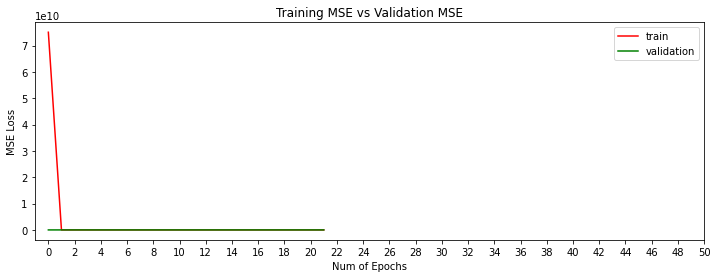

In [402]:
plt.figure(221)

plt.figure(0)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.xticks(np.arange(0, 51, 2.0))
plt.rcParams['figure.figsize'] = (12, 4)
plt.xlabel("Num of Epochs")
plt.ylabel("MSE Loss")
plt.title("Training MSE vs Validation MSE")
plt.legend(['train','validation'])

#### Load Best Model Back In

In [463]:
model = keras.models.load_model('model.12-0.01.h5')
#model = keras.models.load_model('model.09-0.01.h5')

#### Want Last X as input

In [464]:
array_length = len(X)
last_element = X[array_length - 1]

In [465]:
last_element.shape

(100, 2)

In [466]:
last_element = last_element.reshape((1, 100, 2))

In [467]:
yhat = model.predict(last_element, verbose=1)

1/1 [==============================] - 0s 228ms/step


In [468]:
yhat.shape

(1, 30)

In [469]:
yhat

array([[0.11981887, 0.12647569, 0.12624191, 0.1245639 , 0.12725542,
        0.13356982, 0.12983593, 0.13210116, 0.12755631, 0.13793479,
        0.13371742, 0.12878129, 0.12764853, 0.13287073, 0.13334996,
        0.13142449, 0.12631291, 0.13754614, 0.12809603, 0.13741936,
        0.13631748, 0.12929119, 0.12381001, 0.13795102, 0.13746303,
        0.1335483 , 0.13781533, 0.1439818 , 0.14225344, 0.1477748 ]],
      dtype=float32)

In [470]:
yhat_2=yhat.flatten()
yhat_3=yhat_2.reshape(-1, 1)
y_pred=trans_out.inverse_transform(yhat_3)
y_pred=pd.Series(y_pred.flatten())
nov_pred=y_pred[0:27]

In [471]:
nov_test=df_daily_crime[(df_daily_crime['date_time']>='2021-11-01')]
nov_test=nov_test.reset_index()
nov_test=nov_test['Ct']

#### Find LSTMs - Root Mean Squared Error for November

In [472]:
from sklearn.metrics import mean_squared_error

rms = mean_squared_error(nov_pred, nov_test, squared=False)
rms

127.76482816587009

#### Join Test and Pred together as 1 Pandas Data Frame

In [473]:
df_y_pred=pd.DataFrame(nov_pred)
df_y_test=pd.DataFrame(nov_test)

df_y_pred=df_y_pred.reset_index()
df_y_pred.pop('index')
df_y_test=df_y_test.reset_index()
df_y_test.pop('index')

df_y_test.columns=['ct_test']
df_y_pred.columns=['ct_pred']
cmp=df_y_test.join(df_y_pred, how='inner')

cmp['ct_pred']=cmp['ct_pred'].astype(float)

#### LSTM Predicted - Chicago Crime - November 2021

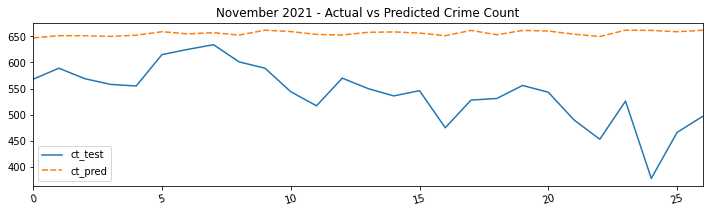

In [474]:
fig = plt.figure(figsize=(12,3))
sns.lineplot(data=cmp).margins(x=0)
plt.xticks(rotation=15)
plt.title('November 2021 - Actual vs Predicted Crime Count')
plt.show()